# Training Notebook (XRay Classification)

This notebook trains a baseline CNN on XRay images using the labels you created in `inspect_dataset.ipynb`.

Requirements: `tensorflow`, `pandas`, `numpy`.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Hyperparameters (centralized)
THRESHOLD = 0.04
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5

# MobileNet settings
TRAIN_BACKBONE = False
DROPOUT = 0.2
LEARNING_RATE = 1e-3
FINE_TUNE = True
UNFREEZE_LAST_N = 20
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LR = 1e-5
DECISION_THRESHOLD = 0.127  # tuned for higher defect recall
USE_CLASS_WEIGHT = True
EARLY_STOPPING_PATIENCE = 3


In [3]:
# Load labeled data (rebuild mapping here so notebook is standalone)
import re
from pathlib import Path
import pandas as pd

csv_path = Path("CrackVoid Ratios") / "Xray Void Ratio.csv"
df = pd.read_csv(csv_path, sep=";")
df["Void rate"] = pd.to_numeric(df["Void rate"], errors="coerce")

df["label"] = (df["Void rate"] >= THRESHOLD).astype(int)

def key_from_row(r):
    return (r["Led Type"], int(r["Panel"]), int(r["LED Number"]))

lookup = {key_from_row(r): r for _, r in df.iterrows()}

xray_root = Path("XRay") / "XRay"
rows = []

for img_path in xray_root.rglob("*.jpg"):
    name = img_path.name
    parts = name.split("_")
    if len(parts) < 5:
        continue
    led_type = parts[1]
    panel = None
    led_num = None
    for part in parts:
        if part.startswith("Panel"):
            panel = int(re.sub(r"[^\d]", "", part))
        if part.startswith("LED"):
            led_num = int(re.sub(r"[^\d]", "", part))
    if panel is None or led_num is None:
        continue
    key = (led_type, panel, led_num)
    if key in lookup:
        r = lookup[key]
        rows.append({
            "path": str(img_path),
            "label": int(r["label"]),
            "void_rate": float(r["Void rate"]),
            "panel": panel,
        })

labeled = pd.DataFrame(rows)
labeled.head()


,path,label,void_rate,panel
0,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.031611,1
1,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.018718,1
2,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.005978,1
3,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.015036,1
4,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.023375,1


In [4]:
labeled["label"].value_counts()
labeled["void_rate"].describe()


count    1800.000000
mean        0.028636
std         0.023569
min         0.000000
25%         0.010268
50%         0.023420
75%         0.039848
max         0.107209
Name: void_rate, dtype: float64

In [5]:
# Train/val/test split with panel-level split to reduce leakage
from sklearn.model_selection import train_test_split

panels = labeled["panel"].unique()
train_panels, temp_panels = train_test_split(panels, test_size=0.3, random_state=42)
val_panels, test_panels = train_test_split(temp_panels, test_size=0.5, random_state=42)

train_df = labeled[labeled["panel"].isin(train_panels)].reset_index(drop=True)
val_df = labeled[labeled["panel"].isin(val_panels)].reset_index(drop=True)
test_df = labeled[labeled["panel"].isin(test_panels)].reset_index(drop=True)

train_df["label"].value_counts(), val_df["label"].value_counts(), test_df["label"].value_counts()
from sklearn.utils import class_weight

classes = np.array([0, 1])
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values,
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict


{0: np.float64(0.656934306569343), 1: np.float64(2.0930232558139537)}

In [6]:
# Create tf.data pipelines
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

def make_ds(df, shuffle=True):
    paths = df["path"].values
    labels = df["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df, shuffle=True)
val_ds = make_ds(val_df, shuffle=False)
test_ds = make_ds(test_df, shuffle=False)

In [7]:
# MobileNetV2 (transfer learning)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = TRAIN_BACKBONE

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict if USE_CLASS_WEIGHT else None,
    callbacks=callbacks,
)

# Fine-tune top layers (optional)
if FINE_TUNE:
    base_model.trainable = True
    if UNFREEZE_LAST_N > 0:
        for layer in base_model.layers[:-UNFREEZE_LAST_N]:
            layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    fine_tune_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
        )
    ]

    fine_tune_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        callbacks=fine_tune_callbacks,
    )

    # Merge histories for plotting
    for k, v in fine_tune_history.history.items():
        history.history[k] += v

model.evaluate(test_ds)


Epoch 1/5


57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 668ms/step - accuracy: 0.6789 - loss: 0.5463 - val_accuracy: 0.7067 - val_loss: 0.5700
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 594ms/step - accuracy: 0.8333 - loss: 0.3552 - val_accuracy: 0.7222 - val_loss: 0.5934
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 614ms/step - accuracy: 0.8533 - loss: 0.3323 - val_accuracy: 0.7200 - val_loss: 0.6498
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 651ms/step - accuracy: 0.8500 - loss: 0.3321 - val_accuracy: 0.7133 - val_loss: 0.6960
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 783ms/step - accuracy: 0.8467 - loss: 0.3568 - val_accuracy: 0.6600 - val_loss: 0.7010
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 736ms/step - accuracy: 0.8622 - loss: 0.2943 - val_accuracy: 0.6689 - val_loss: 0.7041
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 721ms/step - accuracy: 0.8689 - loss: 0.2804 - val_accuracy: 0.7000 - val_loss: 0.6549
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.8756 - loss: 0.2716 - val_accuracy: 0.7067 - val

[0.4515306353569031, 0.7777777910232544]

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step
              precision    recall  f1-score   support

           0     0.9543    0.6963    0.8051       270
           1     0.6759    0.9500    0.7898       180

    accuracy                         0.7978       450
   macro avg     0.8151    0.8231    0.7975       450
weighted avg     0.8429    0.7978    0.7990       450



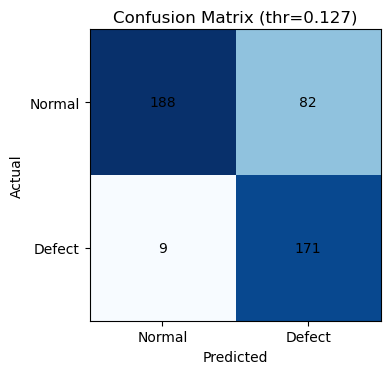

In [9]:
# Confusion matrix on test set
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob >= DECISION_THRESHOLD).astype(int)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix (thr={DECISION_THRESHOLD:.3f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Normal", "Defect"])
plt.yticks([0, 1], ["Normal", "Defect"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()


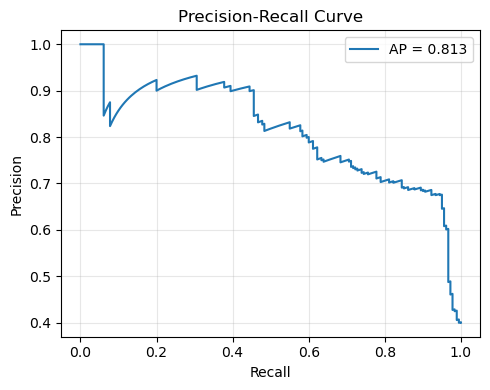

In [10]:
# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Best F1: 0.790 at threshold 0.165
              precision    recall  f1-score   support

           0     0.9543    0.6963    0.8051       270
           1     0.6759    0.9500    0.7898       180

    accuracy                         0.7978       450
   macro avg     0.8151    0.8231    0.7975       450
weighted avg     0.8429    0.7978    0.7990       450



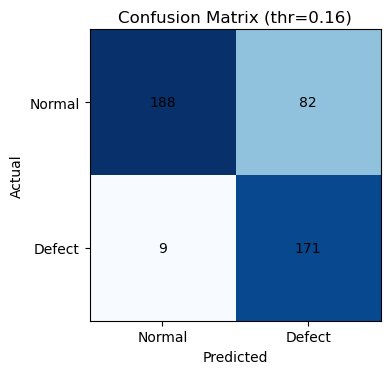

In [11]:
# Decision threshold sweep (maximize F1)
prec_t = precision[:-1]
rec_t = recall[:-1]
f1 = 2 * prec_t * rec_t / (prec_t + rec_t + 1e-8)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]
print(f"Best F1: {f1[best_idx]:.3f} at threshold {best_threshold:.3f}")

# Confusion matrix at best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)
cm_best = confusion_matrix(y_true, y_pred_best)
print(classification_report(y_true, y_pred_best, digits=4))

plt.figure(figsize=(4, 4))
plt.imshow(cm_best, cmap="Blues")
plt.title(f"Confusion Matrix (thr={best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Normal", "Defect"])
plt.yticks([0, 1], ["Normal", "Defect"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_best[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()


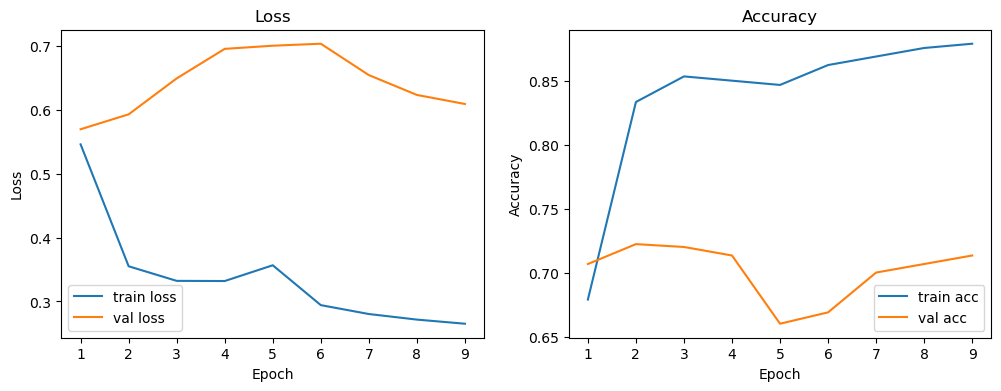

In [12]:
import matplotlib.pyplot as plt

def plot_history(hist):
    h = hist.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, h["loss"], label="train loss")
    plt.plot(epochs, h["val_loss"], label="val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, h["accuracy"], label="train acc")
    plt.plot(epochs, h["val_accuracy"], label="val acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_history(history)


In [13]:
model.save("models/mobilenet_v2_finetuned.keras")
